In [2]:
from scipy import stats
import pandas as pd
import numpy as np
import statsmodels.api as sm
from statsmodels.formula.api import glm
from matplotlib import pyplot as plt

https://towardsdatascience.com/negative-binomial-regression-f99031bb25b4

In [3]:
df = pd.read_excel('data.xlsx', engine='openpyxl')
df.columns = ['Batch', 'Counts']
df.head()

,Batch,Counts
0,B399563,0
1,B399564,0
2,B399565,0
3,B401503,0
4,B401504,66


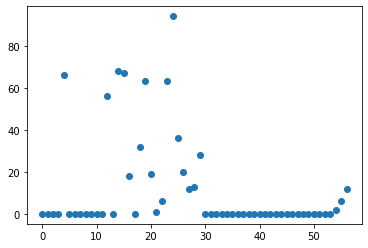

In [4]:
plt.plot(df.Counts, 'o')

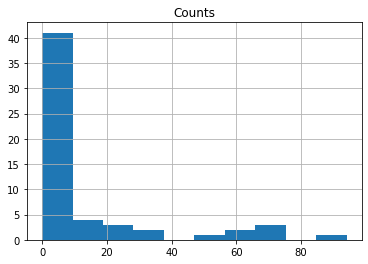

In [5]:
ax = df.hist(column='Counts')

In [6]:
res = glm(
    'Counts ~ 1', data=df, family=sm.families.NegativeBinomial()
).fit()
res.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Counts   No. Observations:                   57
Model:                            GLM   Df Residuals:                       56
Model Family:        NegativeBinomial   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -200.79
Date:                Thu, 06 Jan 2022   Deviance:                       238.49
Time:                        23:04:57   Pearson chi2:                     193.
No. Iterations:                     6                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4820      0.138     18.001      0.000       2.212       2.752
==============================================================================
"""

In [7]:
res1 = glm(
    'Counts ~ 1', data=df, family=sm.families.Poisson()
).fit()
res1.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 Counts   No. Observations:                   57
Model:                            GLM   Df Residuals:                       56
Model Family:                 Poisson   Df Model:                            0
Link Function:                    log   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -992.77
Date:                Thu, 06 Jan 2022   Deviance:                       1887.9
Time:                        23:04:57   Pearson chi2:                 2.50e+03
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      2.4820      0.038     64.817      0.000       2.407       2.557
==============================================================================
"""

In [8]:
from statsmodels.discrete.discrete_model import NegativeBinomial
from statsmodels.discrete.discrete_model import Poisson
from statsmodels.discrete.count_model import ZeroInflatedNegativeBinomialP as sm_zinb

In [9]:
x = np.ones(len(df))
nb_model = NegativeBinomial(endog=df['Counts'], exog=x).fit()
ps = Poisson(endog=df['Counts'], exog=x).fit()
zinb_model = sm_zinb(endog=df['Counts'], exog=x, 
               inflation='probit',
               p=1).fit()

Optimization terminated successfully.
         Current function value: 2.326319
         Iterations: 7
         Function evaluations: 8
         Gradient evaluations: 8
Optimization terminated successfully.
         Current function value: 17.416940
         Iterations 1
Optimization terminated successfully.
         Current function value: 2.231771
         Iterations: 33
         Function evaluations: 40
         Gradient evaluations: 40


In [10]:
nb_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     NegativeBinomial Regression Results                      
==============================================================================
Dep. Variable:                 Counts   No. Observations:                   57
Model:               NegativeBinomial   Df Residuals:                       56
Method:                           MLE   Df Model:                            0
Date:                Thu, 06 Jan 2022   Pseudo R-squ.:               4.136e-11
Time:                        23:04:57   Log-Likelihood:                -132.60
converged:                       True   LL-Null:                       -132.60
Covariance Type:            nonrobust   LLR p-value:                       nan
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const          2.4820      0.428      5.799      0.000       1.643       3.321
alpha         10.3564      2.694      3.845      0.000       5.077      15.636
==============================================================================
"""

In [11]:
zinb_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            Counts   No. Observations:                   57
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                       56
Method:                                      MLE   Df Model:                            0
Date:                           Thu, 06 Jan 2022   Pseudo R-squ.:               6.547e-13
Time:                                   23:04:57   Log-Likelihood:                -127.21
converged:                                  True   LL-Null:                       -127.21
Covariance Type:                       nonrobust   LLR p-value:                       nan
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const     0.3592      0.175      2.050      0.040       0.016       0.703
const             3.5044      0.222     15.810      0.000       3.070       3.939
alpha            31.1725     12.969      2.404      0.016       5.754      56.591
=================================================================================
"""

In [17]:
m = nb_model
mu = np.exp(m.params[0])
alpha = m.params[1]

var = mu + alpha*mu**2
p = mu / var
n = mu * p / (1-p)
mu, var, p, n 

(11.964912280701755,
 1494.5720843842748,
 0.008005577252321684,
 0.09655904043804718)

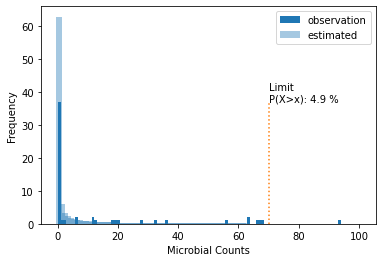

In [18]:
xhat = np.arange(0, 100)
nb = stats.nbinom(n=n, p=p)
yhat = nb.pmf(xhat)
q=0.95

limit = nb.ppf(q)

fig, ax = plt.subplots(ncols=1)

h = ax.hist(df.Counts, bins=xhat.shape[0], label='observation')

ax.bar(xhat+0.5, yhat*100, alpha=0.4, width=2, label='estimated')

ax.vlines(x=limit, ymin=0, ymax=h[0].max(),
          color='C1', linestyle=':')

ax.text(nb.ppf(q), h[0].max(), 
        s=f'Limit\nP(X>x): {100-100*nb.cdf(limit):0.1f} %')

ax.set_ylabel('Frequency')
ax.set_xlabel('Microbial Counts')

ax.legend(loc=1)

11.964912280701755 1494.5720843842748 0.008005577252321684 0.09655904043804718


Text(0, 0.5, 'Probability')

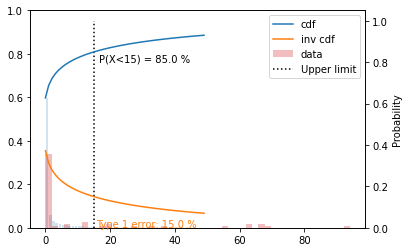

In [34]:
#mu = 10  # CFU/100mL
#var = 2*mu
#p = mu / var
#n = mu * p / (1-p)
print(mu, var, p, n )

ual = 15  # upper acceptance limit'
nb = stats.nbinom(n=n, p=p)
xhat = np.arange(0,50)
yhat = nb.cdf(xhat)
yhat1 = nb.sf(xhat)
x0 = xhat[xhat<ual]
x1 = xhat[xhat>=ual]
yd0 = nb.pmf(x0)
yd1 = nb.pmf(x1)
yd = nb.pmf(xhat)

ax = plt.twinx()
ax.plot(xhat, yhat, label='cdf')
ax.plot(xhat, yhat1, label='inv cdf')

#plt.bar(xhat, yd/yd.max(), alpha=0.2)
plt.bar(x0+0.5, yd0, alpha=0.2)
plt.bar(x1+0.5, yd1, alpha=0.2)

ax.vlines(ymin=0, ymax=1, x=ual, color='black', linestyle=':', label='Upper limit')
ax.text(x=ual*1.1, 
         y=0.8, 
         s=f'P(X<{ual:0.0f}) = {nb.cdf(ual)*100:0.1f} %',
         color='k')

ax.text(x=ual*1.05, 
         y=max(yd1), 
         s=f'Type 1 error: {nb.sf(ual)*100:0.1f} %', 
         color='C1')

h = plt.hist(df.Counts, density=True, 
             bins=xhat.shape[0], 
             alpha=0.3,
             color='C3',
             label='data')

plt.legend(loc=1)
plt.xlabel('Microbial Counts per 100 mL')
plt.ylabel('Probability')


# Zero inflated model

In [130]:
zinb_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                     ZeroInflatedNegativeBinomialP Regression Results                    
=========================================================================================
Dep. Variable:                            Counts   No. Observations:                   57
Model:             ZeroInflatedNegativeBinomialP   Df Residuals:                       56
Method:                                      MLE   Df Model:                            0
Date:                           Thu, 06 Jan 2022   Pseudo R-squ.:               6.547e-13
Time:                                   00:19:33   Log-Likelihood:                -127.21
converged:                                  True   LL-Null:                       -127.21
Covariance Type:                       nonrobust   LLR p-value:                       nan
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
inflate_const     0.3592      0.175      2.050      0.040       0.016       0.703
const             3.5044      0.222     15.810      0.000       3.070       3.939
alpha            31.1725     12.969      2.404      0.016       5.754      56.591
=================================================================================
"""

In [131]:
m = zinb_model
mu = np.exp(m.params[1])
alpha = m.params[2]

var = mu + alpha*mu**2
p = mu / var
n = mu * p / (1-p)
mu, var, p, n

(33.25992067703615,
 34516.9873757246,
 0.0009635812162572295,
 0.03207954606661331)

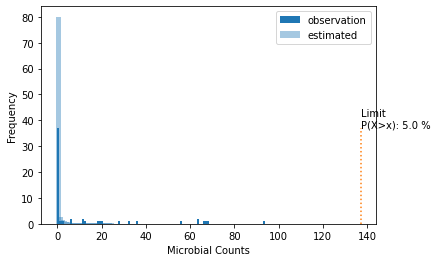

In [132]:
xhat = np.arange(0, 100)
nb = stats.nbinom(n=n, p=p)
yhat = nb.pmf(xhat)
q=0.95

limit = nb.ppf(q)

fig, ax = plt.subplots(ncols=1)

h = ax.hist(df.Counts, bins=xhat.shape[0], label='observation')

ax.bar(xhat+0.5, yhat*100, alpha=0.4, width=2, label='estimated')

ax.vlines(x=limit, ymin=0, ymax=h[0].max(),
          color='C1', linestyle=':')

ax.text(nb.ppf(q), h[0].max(), 
        s=f'Limit\nP(X>x): {100-100*nb.cdf(limit):0.1f} %')

ax.set_ylabel('Frequency')
ax.set_xlabel('Microbial Counts')

ax.legend(loc=1)